In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import numpy as np
from tqdm import tqdm
import argparse
import wandb
from os.path import splitext
from os import listdir
import numpy as np
import os
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image
from torchvision.transforms import functional as TF
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision import models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
# import glob
import wandb
import random
import numpy as np
from model import *
from utils import *
from dataset import *
import time

In [8]:
from rasterio.transform import from_origin

def save_as_geotiff(data, profile, output_path):
    """
    Save a numpy array as a GeoTIFF file with a given raster profile.
    
    :param data: Numpy array to save (2D or 3D array where 3D includes bands)
    :param profile: Dictionary containing raster metadata like crs, transform, etc.
    :param output_path: Path where the GeoTIFF file will be saved
    """
    # Update the profile to accommodate the data dimensions
    profile.update({
        'dtype': data.dtype,
        'height': data.shape[1],
        'width': data.shape[2],
        'count': 1 if data.ndim == 2 else data.shape[0],  # Assuming bands are the first dimension if 3D
        'driver': 'GTiff',
        'nodata': None  # Set this to the appropriate nodata value if required
    })
#     print(profile)

    # Save the data to a GeoTIFF file
    with rasterio.open(output_path, 'w', **profile) as dst:
        if data.ndim == 2:
#             print('2')
            dst.write(data, 1)  # Write data as the first band
        else:
            for i in range(data.shape[0]):
                dst.write(data[i], i + 1)  # Write each band data
                
def calculate_stats(folder_path):
    means = []
    stds = []
    
    # Loop through all files in the directory
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".tif"):
            file_path = os.path.join(folder_path, filename)
            # Open the TIFF file
            with rasterio.open(file_path) as src:
                # Read data, assuming it's a single band
                array = src.read(1)
                # Combine conditions for NoData and zero values
                if src.nodata is not None:
                    mask = (array != src.nodata) & (array != 0)
                else:
                    mask = (array != 0)
                
                # Apply mask
                valid_data = array[mask]
                
                # Calculate mean and std dev and append to lists if valid data exists
                if valid_data.size > 0:
                    means.append(np.mean(valid_data))
                    stds.append(np.std(valid_data))
                else:
                    print(f"Warning: No valid data in file {filename} after masking. Skipping statistics.")

    # Calculate overall statistics
    overall_mean = np.mean(means) if means else 0
    overall_std = np.mean(stds) if stds else 0

    return overall_mean, overall_std

In [4]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
field_name = 'Ellis'

In [12]:
dem_dir = f'/home/macula/SMATousi/Gullies/SO_Paper/data/{field_name}/dem/'
so_dir = f'/home/macula/SMATousi/Gullies/SO_Paper/data/{field_name}/dem/'
rgb_dir = f'/home/macula/SMATousi/Gullies/SO_Paper/data/{field_name}/rgb/'
pretrained_model_path = '/home/macula/SMATousi/cluster/docker-images/dem2so_more_data/pre_models/B3_rn50_moco_0099_ckpt.pth'


mean, std = calculate_stats(dem_dir)
print("Overall Mean:", mean)
print("Overall Standard Deviation:", std)

class RGB_RasterTransform_Geo:
    """
    A custom transform class for raster data.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        dem, so, rgb = sample['DEM'], sample['SO'], sample['RGB']
        dem_meta, so_meta, rgb_meta = sample['DEM_transform'], sample['SO_transform'], sample['RGB_transforms']

        # Random horizontal flipping
        # if torch.rand(1) > 0.5:
        #     dem = TF.hflip(dem)
        #     so = TF.hflip(so)

        # # Random vertical flipping
        # if torch.rand(1) > 0.5:
        #     dem = TF.vflip(dem)
        #     so = TF.vflip(so)

        # Convert numpy arrays to tensors
        dem = TF.to_tensor(dem)
        so = TF.to_tensor(so)
        rgb_images = [TF.to_tensor(image) for image in rgb]
        float_rgb_images = [image.float() for image in rgb_images]
        # rgb_images = rgb_images.float()

        dem = TF.normalize(dem, mean, std)

        so = so.long()

        return {'DEM': dem, 'SO': so.squeeze(), 'RGB': float_rgb_images,
                'DEM_transform' : dem_meta, 'SO_transform' : so_meta, 'RGB_transforms' : rgb_meta}

transform = RGB_RasterTransform_Geo()
    
dataset = RGB_RasterTilesDataset_Geo(dem_dir=dem_dir, so_dir=so_dir, rgb_dir=rgb_dir, transform=transform)
# dataset = RGB_RasterTilesDataset_Geo(dem_dir=dem_dir, so_dir=so_dir, rgb_dir=rgb_dir)

batch_size = 1
learning_rate = 0.0001
epochs = 1
number_of_workers = 0
image_size = 128
val_percent = 0.0

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=number_of_workers, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=number_of_workers, pin_memory=True, drop_last=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

model = RGB_DEM_to_SO(resnet_output_size=(8, 8), 
                            fusion_output_size=(128, 128), 
                            model_choice = "Unet_1", 
                            resnet_saved_model_path=pretrained_model_path,
                            dropout_rate=0.5).to(device)

from torch.optim import Adam
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

state_dict = torch.load('./artifacts/model_epoch_200:v6/model_epoch_200.pth')
state_dict_new = torch.load('./artifacts/new_loss/model_epoch_600.pth')

new_state_dict = {k.replace('module.', ''): v for k, v in state_dict_new.items()}
model.load_state_dict(new_state_dict)

print(len(train_loader))

model.eval()

for i, batch in enumerate(tqdm(train_loader)):
    
    dem = batch['DEM'].to(device)
    so = batch['SO'].to(device)
    rgbs = [batch['RGB'][k].to(device) for k in range(6)]

    permute_rgbs = [torch.permute(image,(0,2,1,3)) for image in rgbs]


    val_outputs = model(dem, permute_rgbs)

    pred = F.softmax(val_outputs, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    
    profile = {
    'transform': batch['SO_transform'],  # Example values: (west, north, xsize, ysize)
    'crs': 'EPSG:4326',  # Standard WGS84 CRS
    }

    # Path to save the GeoTIFF file
    root_path = f'/home/macula/SMATousi/Gullies/SO_Paper/data/{field_name}/Predicted_SO_tiles_N_min'
    os.makedirs(root_path, exist_ok=True)
    output_file_path = f'{root_path}/{i}.tif'
    

    # Call the function to save the file
    save_as_geotiff(pred.float().cpu().numpy(), profile, output_file_path)
    
    

input_folder = f'/home/macula/SMATousi/Gullies/SO_Paper/data/{field_name}/Predicted_SO_tiles_N_min/'  # Update this path to your folder path
output_filepath = f'/home/macula/SMATousi/Gullies/SO_Paper/data/{field_name}/Merged_Predicted_So_N_min_new_loss.tif'  # Set your output file path

merge_tiffs(input_folder, output_filepath)

Overall Mean: 217.71289
Overall Standard Deviation: 1.9757788
cuda
256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:10<00:00,  3.64it/s]


AttributeError: 'function' object has no attribute 'glob'

In [23]:
merge_tiffs(input_folder, output_filepath)

Merge completed successfully. Output saved at: /home/macula/SMATousi/Gullies/SO_Paper/data/Ellis/Merged_Predicted_So_N_min_new_loss.tif


256

In [139]:
model.eval()
train_iter = iter(train_loader)

In [10]:
batch = next(train_iter)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:09<00:00,  3.71it/s]


In [141]:

input_folder = f'/home/macula/SMATousi/Gullies/SO_Paper/data/{field_name}/Predicted_SO_tiles_N_min/'  # Update this path to your folder path
output_filepath = f'/home/macula/SMATousi/Gullies/SO_Paper/data/{field_name}/Merged_Predicted_So_N_min.tif'  # Set your output file path

merge_tiffs(input_folder, output_filepath)

IndexError: list index out of range

In [31]:
pred = F.softmax(val_outputs, dim=1)              
pred = torch.argmax(pred, dim=1).squeeze(1)

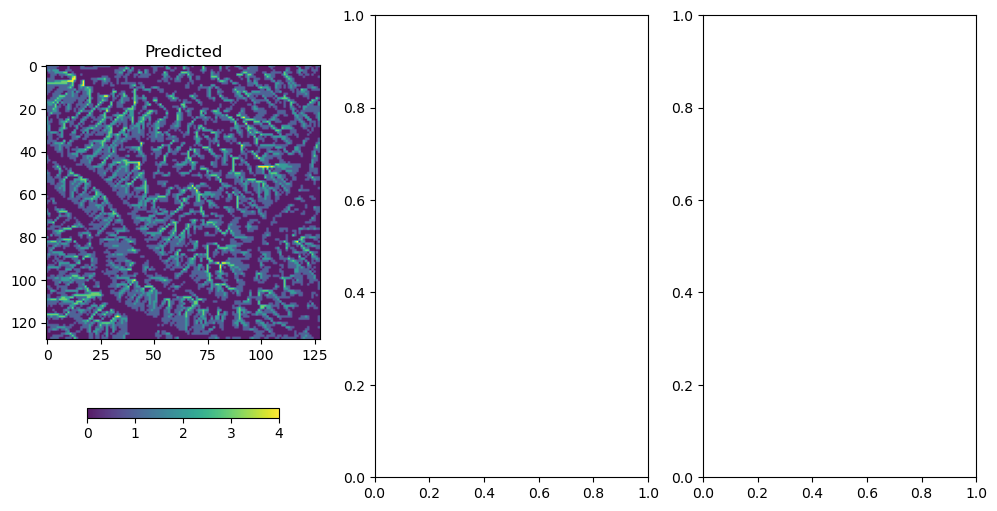

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# Plot for predicted
im1 = ax1.imshow(pred.cpu().numpy().squeeze(), alpha=0.9)
ax1.set_title("Predicted")
fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=0.7)

# Plot for ground truth
# im2 = ax2.imshow(so.cpu().numpy().squeeze(), alpha=0.9)
# ax2.set_title("Ground Truth")
# fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=0.7)

# im3 = ax3.imshow(heatmap, cmap='hot', alpha=0.9)
# ax3.set_title("IoU Heatmap")
# fig.colorbar(im3, ax=ax3, orientation='horizontal', shrink=0.7)

plt.show()

In [11]:
import rasterio
from rasterio.transform import from_origin

def save_as_geotiff(data, profile, output_path):
    """
    Save a numpy array as a GeoTIFF file with a given raster profile.
    
    :param data: Numpy array to save (2D or 3D array where 3D includes bands)
    :param profile: Dictionary containing raster metadata like crs, transform, etc.
    :param output_path: Path where the GeoTIFF file will be saved
    """
    # Update the profile to accommodate the data dimensions
    profile.update({
        'dtype': data.dtype,
        'height': data.shape[1],
        'width': data.shape[2],
        'count': 1 if data.ndim == 2 else data.shape[0],  # Assuming bands are the first dimension if 3D
        'driver': 'GTiff',
        'nodata': None  # Set this to the appropriate nodata value if required
    })
#     print(profile)

    # Save the data to a GeoTIFF file
    with rasterio.open(output_path, 'w', **profile) as dst:
        if data.ndim == 2:
#             print('2')
            dst.write(data, 1)  # Write data as the first band
        else:
            for i in range(data.shape[0]):
                dst.write(data[i], i + 1)  # Write each band data

In [20]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import os
import glob



In [22]:
def merge_tiffs(input_folder, output_filepath):
    """
    Merge multiple GeoTIFF files into a single larger TIFF file.

    :param input_folder: Folder containing all TIFF files to merge.
    :param output_filepath: Path to save the merged TIFF file.
    """
    # Search for TIFF files in the folder
    search_criteria = "*.tif"
    query = os.path.join(input_folder, search_criteria)
    tif_files = glob.glob(query)

    # List to hold open datasets
    src_files_to_mosaic = []

    # Open and append each TIFF file to the list
    for filepath in tif_files:
        src = rasterio.open(filepath)
        src_files_to_mosaic.append(src)

    # Merge function from rasterio
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Copy the metadata
    out_meta = src_files_to_mosaic[0].meta.copy()

    # Update the metadata to reflect the number of layers
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "crs": src_files_to_mosaic[0].crs
    })

    # Write the mosaic raster to the new file
    with rasterio.open(output_filepath, "w", **out_meta) as dest:
        for i in range(1, mosaic.shape[0]+1):
            dest.write(mosaic[i-1], i)

    # Close all rasterio opened files
    for src in src_files_to_mosaic:
        src.close()

    print("Merge completed successfully. Output saved at:", output_filepath)

In [17]:
glob(os.path.join(input_folder, "*.tif"))

['/home/macula/SMATousi/Gullies/SO_Paper/data/Ellis/Predicted_SO_tiles_N_min/108.tif',
 '/home/macula/SMATousi/Gullies/SO_Paper/data/Ellis/Predicted_SO_tiles_N_min/70.tif',
 '/home/macula/SMATousi/Gullies/SO_Paper/data/Ellis/Predicted_SO_tiles_N_min/245.tif',
 '/home/macula/SMATousi/Gullies/SO_Paper/data/Ellis/Predicted_SO_tiles_N_min/212.tif',
 '/home/macula/SMATousi/Gullies/SO_Paper/data/Ellis/Predicted_SO_tiles_N_min/31.tif',
 '/home/macula/SMATousi/Gullies/SO_Paper/data/Ellis/Predicted_SO_tiles_N_min/16.tif',
 '/home/macula/SMATousi/Gullies/SO_Paper/data/Ellis/Predicted_SO_tiles_N_min/253.tif',
 '/home/macula/SMATousi/Gullies/SO_Paper/data/Ellis/Predicted_SO_tiles_N_min/49.tif',
 '/home/macula/SMATousi/Gullies/SO_Paper/data/Ellis/Predicted_SO_tiles_N_min/3.tif',
 '/home/macula/SMATousi/Gullies/SO_Paper/data/Ellis/Predicted_SO_tiles_N_min/18.tif',
 '/home/macula/SMATousi/Gullies/SO_Paper/data/Ellis/Predicted_SO_tiles_N_min/10.tif',
 '/home/macula/SMATousi/Gullies/SO_Paper/data/Ellis

In [62]:
2048/128

16.0

In [69]:
dem_file = '/home/macula/SMATousi/Gullies/SO_Paper/data/Bayfarm/dem/dem_tile_17.tif'
with rasterio.open(dem_file) as src:
    dem_image = src.read(1)
    dem_meta = src.profile

In [70]:
dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 128, 'height': 128, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(9.99999999999801e-06, 0.0, -92.2043776,
       0.0, -1.0000213243706924e-05, 38.9015730991922), 'tiled': False, 'interleave': 'band'}